# Path Planning and Staying in the Presence of Obstacles: Solution by RRT and MILP

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Define Parameters

In [2]:
# Define system matrices
tau = 0.1
A = np.array([[1, tau, 0, 0], 
              [0, 1, 0, 0],
              [0, 0, 1, tau],
              [0, 0, 0, 1]])  
B = np.array([[0.5 * tau ** 2, 0],
              [tau, 0],
              [0, 0.5 * tau ** 2],
              [0, tau]])  


In [3]:
# Define operational domain
x_limits = [0, 5]
y_limits = [0, 5]
vel_limits = [-1, 1]

# Define unsafe regions (obstacles)
unsafe_regions = [
    [[1, -1, 1, -1], [2, 1, 2, 1]],
    [[1, -1, 3, -1], [2, 1, 5, 1]],
    [[3, -1, 1, -1], [4, 1, 2, 1]],
    [[3, -1, 2.5, -1], [4, 1, 3.5, 1]]
]

# Define target set
target_set = [[4, -0.1, 4, -0.1], [5, 0.1, 5, 0.1]]

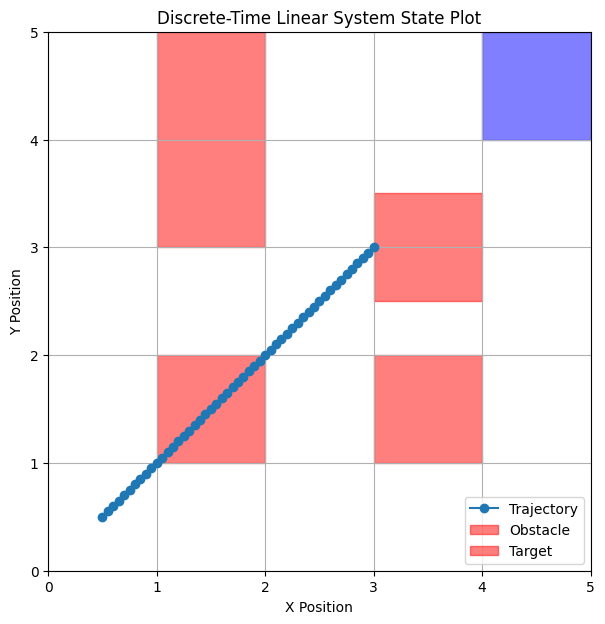

In [4]:
# Parameters
tend = 50

# Initialization
x_init = np.array([0.5, 0.5, 0.5, 0.5])  # Initial position and velocity
u_init = np.array([0, 0])
trajectory = [x_init]
input = [u_init]

for k in range(tend):
    x_next = A @ trajectory[-1] + B @ input[-1] 
    trajectory.append(x_next)

trajectory = np.array(trajectory)

# Plot trajectory of x over time
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_title("Discrete-Time Linear System State Plot")

ax.plot(trajectory[:, 0], trajectory[:, 2], marker="o", linestyle="-", label="Trajectory")

# Plot obstacles and target set
for region in unsafe_regions:
    bottom_left = [region[0][0], region[0][2]]
    width = region[1][0] - region[0][0]
    height = region[1][2] - region[0][2]
    ax.add_patch(plt.Rectangle(bottom_left, width, height, color='red', alpha=0.5, label="Obstacle"))

bottom_left = [target_set[0][0], target_set[0][2]]
width = target_set[1][0] - target_set[0][0]
height = target_set[1][2] - target_set[0][2]
ax.add_patch(plt.Rectangle(bottom_left, width, height, color='blue', alpha=0.5, label="Target"))

ax.legend(["Trajectory","Obstacle","Target"])
plt.grid(True)
plt.show()

### Helper Functions

In [5]:
def is_out_of_bounds(state):
    """Check if the state is out of the allowed operational domain."""
    x, vx, y, vy = state
    if not (x_limits[0] <= x <= x_limits[1]):
        return True
    if not (y_limits[0] <= y <= y_limits[1]):
        return True
    if not (vel_limits[0] <= vx <= vel_limits[1]):
        return True
    if not (vel_limits[0] <= vy <= vel_limits[1]):
        return True
    return False

def is_inside_obstacle(state):
    """Check if the state is inside any of the obstacles."""
    x, _, y, _ = state  # We only care about position
    for lower, upper in unsafe_regions:
        if lower[0] <= x <= upper[0] and lower[2] <= y <= upper[2]:
            return True  # Inside an obstacle
    return False

def is_illegal_state(state):
    """Determine if the state is illegal (out of bounds or inside an obstacle)."""
    return is_out_of_bounds(state) or is_inside_obstacle(state)

def distance_to_target(state):
    """Compute the Euclidean distance from the state to the center of the target set."""
    position = np.array([state[0], state[2]])  # Extract x and y positions
    target_position = np.array([4.5, 4.5])
    return np.linalg.norm(position - target_position)

# Example test cases
test_states = [
    np.array([0.5, 0.5, 0.5, 0.5]),  # Valid
    np.array([5.1, 0, 4, 0]),  # Out of bounds (x)
    np.array([1.5, 0, 1.5, 0]),  # Inside an obstacle
    np.array([4.5, 0, 4.5, 0]),  # Target set center
]

# Run tests
for i, state in enumerate(test_states):
    print(f"State {i+1}: {state}")
    print(f"  - Out of bounds: {is_out_of_bounds(state)}")
    print(f"  - Inside obstacle: {is_inside_obstacle(state)}")
    print(f"  - Illegal state: {is_illegal_state(state)}")
    print(f"  - Distance to target: {distance_to_target(state):.2f}")
    print()


# functions to compare two x_k+1 see which is closer to the target zone

State 1: [0.5 0.5 0.5 0.5]
  - Out of bounds: False
  - Inside obstacle: False
  - Illegal state: False
  - Distance to target: 5.66

State 2: [5.1 0.  4.  0. ]
  - Out of bounds: True
  - Inside obstacle: False
  - Illegal state: True
  - Distance to target: 0.78

State 3: [1.5 0.  1.5 0. ]
  - Out of bounds: False
  - Inside obstacle: True
  - Illegal state: True
  - Distance to target: 4.24

State 4: [4.5 0.  4.5 0. ]
  - Out of bounds: False
  - Inside obstacle: False
  - Illegal state: False
  - Distance to target: 0.00



## Method 1. Mixed Integer Linear Programming

Start with Problem Formation:

Define $N$ as the horizontal variable (time to reach the terminal set), which we will optimize, $\gamma$ as our choice of weight which we may use to balance our cost of control and terminal time.
$$\begin{equation} min N + \gamma\sum^n_{k=0}||u_k|| \end{equation}$$
$s.t.$
$$\begin{equation}\tag{IC}  x_0 = x_{init} \end{equation}$$
$$\begin{equation}\tag{DE}  x_{k+1} = Ax_k+Bu_k\end{equation}$$
$$\begin{equation}\tag{BC1}  x_{k+1} \in \mathcal{X} \end{equation}$$
$$\begin{equation}\tag{BC2}  u_k \in \mathcal{U} \end{equation}$$
$$\begin{equation}\tag{Obstacle Condition}  x_{k+1} \notin \mathcal{X}_U^j, 1 \leq j \leq N_o \end{equation}$$
$$\begin{equation}\tag{Target Condition}  x_{k+1} \in \mathcal{X}_T \end{equation}$$

Where
$$0\leq k \leq N $$
$$ A = 
\begin{bmatrix} 
1 & \tau & 0 & 0\\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & \tau \\
0 & 0 & 0 & 1
\end{bmatrix},
B = 
\begin{bmatrix} 
0.5\tau^2 & 0\\
\tau & 0 \\
0 & 0.5\tau^2 \\
0 & \tau
\end{bmatrix}
$$

One way of formulating the inequalities so it becomes a MPC-MILP (Model Predictive Control Mixed Integer Linear Programming) and can be solved using the algorithms presented in Schouwenaars et al (2001), is to use binary variables.

Consider the obstacles set as the intersection of 4 half planes:
$$\mathcal{X}^j_U = \{p_jCx \leq q_j\}$$
where $p_j$ denotes the constant matrix in the left hand side of the half-plane inequalities defining obstacle $\mathcal{X}^j_U$, and $q_j$ denotes the right hand side of the half plane inequalities, $C$ denotes the matrix that extracts position information from the state vector $x$.

E.g. $\mathcal{X}^1_U$, defined by the lower left extreme [1, 1] and upper right extreme [2, 2] can be represented as:
$$
\mathcal{X}^1_U = \{p_1Cx \leq q_1 \}
$$
where
$$ C= 
\begin{bmatrix} 
1 & 0 & 0 & 0\\
0 & 0 & 1 & 0 \\
\end{bmatrix}
$$
$$
p_1 = 
\begin{bmatrix} 
-1 & 0\\
1 & 0 \\
0 & -1 \\
0 & 1
\end{bmatrix}
$$
$$
q_1 = 
\begin{bmatrix} 
-1\\
2 \\
-1 \\
2
\end{bmatrix}
$$

To ensure the inequality above would never hold for any $x_k$, we use big-M (a large number $M$ as a penalty for entering the obstacle) and binary variables $b_j^{obs} = \{1, 0\}$ for each obstacles. 1 if $x_k$ is outside obstacle j, and 0 if $x_k$ is inside. We also introduced $b_i^{hor}$ to keep track of obstacles we have passed horizontally (=1 if passed the obstacle, =0 if not yet pass) and a small buffer $\epsilon > 0$ to ensure $x_k$ does not graze the obstacle:
$$-p_j^{obs}Cx \leq -q_j^{obs} + M(1 - b_j^{obs}) - \epsilon + M\sum^{k-1}_{i=0} b^{hor}_i$$

In [ ]:
# The obstacle constraints using MILP

# Example
# Obstacle Constraint for Obstacle 1: [1, 1] x [2, 2]
# -p1*Cx[k] <= -q_1 + M(1 - b[k]) - epsilon
# P1 = np.array([[-1, 0],
#               [1, 0],
#               [0, -1],
#               [0, 1]])
# Q1 = np.array([[-1],
#                [2],
#                [-1],
#                [2]])

# C = np.array([[1, 0, 0, 0],
#               [0, 0, 1, 0]])

# Obstacles
obstacles = [
    (np.array([[-1, 0],
               [1, 0],
               [0, -1],
               [0, 1]]),
     np.array([[-1],
               [2],
               [-1],
               [2]])), # Obstacle 1

    (np.array([[-1, 0],
               [1, 0],
               [0, -1],
               [0, 1]]),
     np.array([[-1],
               [2],
               [-3],
               [5]])), # Obstacle 2

    (np.array([[-1, 0],
               [1, 0],
               [0, -1],
               [0, 1]]),
     np.array([[-3],
               [4],
               [-1],
               [2]])), # Obstacle 3

    (np.array([[-1, 0],
               [1, 0],
               [0, -1],
               [0, 1]]),
     np.array([[-3],
               [4],
               [-2.5],
               [3.5]])) # Obstacle 4
]

obstacles2 = [] # Possibly another set of obstacles, for Extension 3


In [321]:
N = 300  # Time horizon (Current best: 53)
M = 1000  # Big-M constant
epsilon = 0.1
gamma = 0.1

### Implementation with DOCPLEX

Due to the limitation of DOCPLEX, I am unable to implement anything further with it.

In [10]:
# first import the Model class from docplex.mp
from docplex.mp.model import Model

In [72]:
# create one model instance, with a name
milp_model = Model(name='Reach Avoid')

In [74]:
# Decision variables
# k represents time step k, i represents row of state/control vector

# N = milp_model.integer_var(name=f"{N} steps") 
x = [
        [milp_model.continuous_var(name=f"x_{k}_{i}") for i in range(4)]
    for k in range(N+1)] # x[k][i] ith row of state vector x at k time step
u = [   
        [milp_model.continuous_var(name=f"u_{k}_{i}") for i in range(2)]
    for k in range(N)] # u[k][i] ith row of control vector u at k time step

w = [   
        [milp_model.continuous_var(name=f"w_{k}_{i}", lb=0) for i in range(2)]
    for k in range(N)] # This is same as u but the absolute value of it, taken from Schouwenaars paper

b = [
        [milp_model.binary_var(name=f"b_{k}_{n}")for n in range(4)]
    for k in range(N)] # Test binary variable for the first obstacle, b[k][n] is the binary variable for the nth row of the obstacle avoidance constraint at timestep k

# b = [
#         [
#             [milp_model.binary_var(name=f"b_{k}_{j}_{n}")]
#         for j in range(4)]
#     for k in range(N)] # b[k][j][n]

# bh = {(k, j): milp_model.binary_var(name=f"Horizon b_{k}_{j}") for k in range(N) for j in range(len(unsafe_regions))}


In [ ]:
# Initial state
x_init = np.array([0.5, 0.5, 0.5, 0.5])
for i in range(4):
    milp_model.add_constraint(x[0][i] == x_init[i])

for k in range(N):

    # Dynamics constraints
    for i in range(4):
        milp_model.add_constraint(
            x[k + 1][i] == sum(A[i, j] * x[k][j] for j in range(4)) 
                           + sum(B[i, j] * u[k][j] for j in range(2))
        )
        
    # Control Constraints
    for i in range(2):
        milp_model.add_constraint(u[k][i] >= -1)
        milp_model.add_constraint(u[k][i] <= 1)
        milp_model.add_constraint(w[k][i] >= u[k][i])
        milp_model.add_constraint(w[k][i] >= -u[k][i])

    # Operational domain:
    for i in range(4):
        if i == 1 or i == 3:
            milp_model.add_constraint(x[k][i] >= -1)
            milp_model.add_constraint(x[k][i] <= 1)
        milp_model.add_constraint(x[k][i] >= 0)
        milp_model.add_constraint(x[k][i] <= 5)


In [ ]:
for k in range(1, N):
    # Obstacle avoidance constraints
    x_pos = [x[k][0], x[k][2]]

    for i in range(4):
        lhs = -(P1[i, 0] * x_pos[0]+P1[i, 1] * x_pos[1])
        rhs = -Q1[i, 0] + M * (1 - b[k][i]) - epsilon

        milp_model.add_constraint(lhs <= rhs)
        
    milp_model.add_constraint(
        sum(b[k][i] for i in range(4)) >= 1
    )

    # for j, region in enumerate(unsafe_regions):
    #     lower, upper = region
    #     milp_model.add_constraint(x[k, 0] <= lower[0] - epsilon + M * (1 - z[k, j]))
    #     milp_model.add_constraint(x[k, 0] >= upper[0] + epsilon - M * z[k, j])
    #     milp_model.add_constraint(x[k, 2] <= lower[2] - epsilon + M * (1 - z[k, j]))
    #     milp_model.add_constraint(x[k, 2] >= upper[2] + epsilon - M * z[k, j])
    # milp_model.add_constraint(sum(z[k, j] for j in range(len(unsafe_regions))) >= 1)


In [ ]:
# Target constraint
milp_model.add_constraint(x[N][0] >= target_set[0][0])
milp_model.add_constraint(x[N][0] <= target_set[1][0])
milp_model.add_constraint(x[N][2] >= target_set[0][2])
milp_model.add_constraint(x[N][2] <= target_set[1][2])

# Target velocity constraint
# milp_model.add_constraint(x[N][1] >= target_set[0][1])
# milp_model.add_constraint(x[N][1] <= target_set[1][1])
# milp_model.add_constraint(x[N][3] >= target_set[0][3])
# milp_model.add_constraint(x[N][3] <= target_set[1][3])


# milp_model.add_constraint(x[N][1] <= 1e-3)
# milp_model.add_constraint(x[N][3] <= 1e-3)
# Stay constraint (This could be shaped to that for all k > N, velocities of x and u are 0?)
# milp_model.add_constraint(x[N + 1][0] >= target_set[0][0])
# milp_model.add_constraint(x[N + 1][0] <= target_set[1][0])
# milp_model.add_constraint(x[N + 1][2] >= target_set[0][2])
# milp_model.add_constraint(x[N + 1][2] <= target_set[1][2])
# for i in range(4):
#     milp_model.add_constraint(
#         x[N + 1][i] == sum(A[i, j] * x[N][j] for j in range(4))
#         )
# This doesn't work yet


docplex.mp.LinearConstraint[](x_40_3,LE,0.9)

In [ ]:
# Objective: Minimize control effort
obj_fn = sum((1 + gamma * w[k][i]) for k in range(N) for i in range(2))
milp_model.set_objective('min', obj_fn)

# Solve model
solution = milp_model.solve()

# Check solution
if solution:
    print("Solution found:")
    milp_model.print_solution()
else:
    print("No feasible solution found.")

In [79]:
milp_model.print_information()

Model: Reach Avoid
 - number of variables: 484
   - binary=160, integer=0, continuous=324
 - number of constraints: 972
   - linear=972
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP


In [80]:
for i in range(4):
    print(f"{solution.get_value(x[40][i])} == {sum(A[i, j] * solution.get_value(x[39][j]) for j in range(4))+ sum(B[i, j] * solution.get_value(u[39][j]) for j in range(2))}")

                        

3.9999999999999987 == 3.9999999999999987
0.8945205479452051 == 0.8945205479452051
3.9999999999999987 == 3.9999999999999987
0.8945205479452051 == 0.8945205479452051


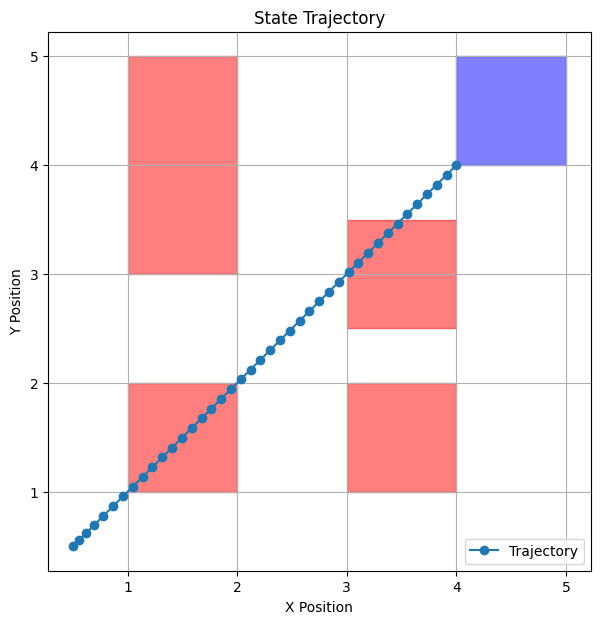

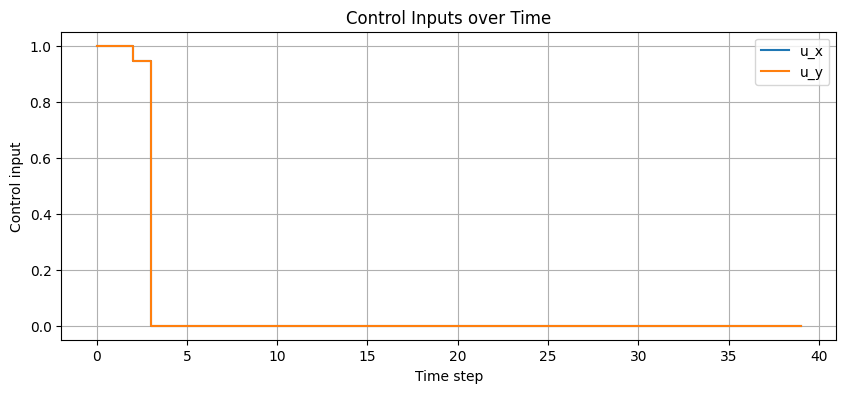

In [81]:
# Extract trajectory
trajectory = np.array([
    [solution.get_value(x[k][i]) for i in range(4)]
    for k in range(N + 1)
])

# Extract control inputs
control_inputs = np.array([
    [solution.get_value(u[k][i]) for i in range(2)]
    for k in range(N)
])

# For the stay part, we can extend the trajectory?

# ---- Plot Trajectory ----
plt.figure(figsize=(7, 7))
plt.plot(trajectory[:, 0], trajectory[:, 2], marker='o', label='Trajectory')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('State Trajectory')
plt.grid(True)
plt.legend()

# Plot Obstacles
for region in unsafe_regions:
    lower, upper = region
    bottom_left = [lower[0], lower[2]]
    width = upper[0] - lower[0]
    height = upper[2] - lower[2]
    plt.gca().add_patch(plt.Rectangle(bottom_left, width, height, color='red', alpha=0.5))

# Plot Target Set
bottom_left = [target_set[0][0], target_set[0][2]]
width = target_set[1][0] - target_set[0][0]
height = target_set[1][2] - target_set[0][2]
plt.gca().add_patch(plt.Rectangle(bottom_left, width, height, color='blue', alpha=0.5))

plt.show()

# ---- Plot Control Inputs ----
plt.figure(figsize=(10, 4))
plt.step(range(N), control_inputs[:, 0], label='u_x')
plt.step(range(N), control_inputs[:, 1], label='u_y')
plt.xlabel('Time step')
plt.ylabel('Control input')
plt.title('Control Inputs over Time')
plt.grid(True)
plt.legend()
plt.show()

### Implementation with GUROBI

In [281]:
import gurobipy as gp
from gurobipy import GRB

In [330]:
milp_guro_model = gp.Model("ReachAvoidGurobi")

In [331]:
# Decision variables
x = milp_guro_model.addVars(N + 1, 4, vtype=GRB.CONTINUOUS, name="x")
u = milp_guro_model.addVars(N, 2, lb=-1, ub=1, vtype=GRB.CONTINUOUS, name="u")
w = milp_guro_model.addVars(N, 2, lb=0, vtype=GRB.CONTINUOUS, name="w")
b = {}
for obs_idx, (P, Q) in enumerate(obstacles):
    for k in range(N):
        for i in range(4):
            b[k, obs_idx, i] = milp_guro_model.addVar(vtype=GRB.BINARY, name=f"b_{k}_{obs_idx}_{i}")

# Extension 2.0
# Adding a horizontal variable
# b_hor = {}
# for obs_idx, (P, Q) in enumerate(obstacles):
#     for k in range(N):
#         b_hor[k, obs_idx] = milp_guro_model.addVar(vtype=GRB.BINARY, name=f"b_hor_{k}_{obs_idx}")

# Constraints
# Initial state
x_init = np.array([0.5, 0.5, 0.5, 0.5])
for i in range(4):
    milp_guro_model.addConstr(x[0, i] == x_init[i])

# Dynamics constraints
for k in range(N):
    for i in range(4):
        milp_guro_model.addConstr(
            x[k + 1, i] == gp.quicksum(A[i, j] * x[k, j] for j in range(4)) +
                          gp.quicksum(B[i, j] * u[k, j] for j in range(2))
        )

    # State constraints
    milp_guro_model.addConstrs((x[k, i] >= 0 for i in range(4)))
    milp_guro_model.addConstrs((x[k, i] <= 5 for i in range(4)))
    milp_guro_model.addConstr(x[k, 1] >= -1)
    milp_guro_model.addConstr(x[k, 1] <= 1)
    milp_guro_model.addConstr(x[k, 3] >= -1)
    milp_guro_model.addConstr(x[k, 3] <= 1)

    # w absolute value constraint
    for i in range(2):
        milp_guro_model.addConstr(w[k, i] >= u[k, i])
        milp_guro_model.addConstr(w[k, i] >= -u[k, i])

# Obstacle avoidance
for obs_idx, (P, Q) in enumerate(obstacles):
    for k in range(1, N):
        
        # Horizontal pass condition (update rule)
        # milp_guro_model.addConstr(x[k, 0] >= Q[1, 0] + epsilon - M * (1 - b_hor[k, obs_idx]))
        # milp_guro_model.addConstr(x[k, 0] <= Q[1, 0] + M * b_hor[k, obs_idx])

        for i in range(4):
            lhs = -(P[i, 0] * x[k, 0] + P[i, 1] * x[k, 2])
            rhs = -Q[i, 0] + M * (1 - b[k, obs_idx, i]) - epsilon #+ M * gp.quicksum(b_hor[t, obs_idx] for t in range(k))
            milp_guro_model.addConstr(lhs <= rhs)
        milp_guro_model.addConstr(gp.quicksum(b[k, obs_idx, i] for i in range(4)) >= 1)

# for k in range(1, N):
#     for i in range(4):
#         lhs = -(P1[i, 0] * x[k, 0] + P1[i, 1] * x[k, 2])
#         rhs = -Q1[i, 0] + M * (1 - b[k, i]) - epsilon
#         milp_guro_model.addConstr(lhs <= rhs)
#     milp_guro_model.addConstr(gp.quicksum(b[k, i] for i in range(4)) >= 1)



In [305]:
# Target constraint
milp_guro_model.addConstr(x[N, 0] >= target_set[0][0])
milp_guro_model.addConstr(x[N, 0] <= target_set[1][0])
milp_guro_model.addConstr(x[N, 2] >= target_set[0][2])
milp_guro_model.addConstr(x[N, 2] <= target_set[1][2])

# Target velocity constraint
milp_guro_model.addConstr(x[N, 1] >= target_set[0][1])
milp_guro_model.addConstr(x[N, 1] <= target_set[1][1])
milp_guro_model.addConstr(x[N, 3] >= target_set[0][3])
milp_guro_model.addConstr(x[N, 3] >= target_set[1][3])


<gurobi.Constr *Awaiting Model Update*>

In [340]:
# Extension 3.1 A different target set
bottom_right_target = [[4, -0.1, 0, -0.1], [5, 0.1, 1, 0.1]]

# Target constraint
milp_guro_model.addConstr(x[N, 0] >= bottom_right_target[0][0])
milp_guro_model.addConstr(x[N, 0] <= bottom_right_target[1][0])
milp_guro_model.addConstr(x[N, 2] >= bottom_right_target[0][2])
milp_guro_model.addConstr(x[N, 2] <= bottom_right_target[1][2])

# Target velocity constraint
milp_guro_model.addConstr(x[N, 1] >= bottom_right_target[0][1])
milp_guro_model.addConstr(x[N, 1] <= bottom_right_target[1][1])
milp_guro_model.addConstr(x[N, 3] >= bottom_right_target[0][3])
milp_guro_model.addConstr(x[N, 3] >= bottom_right_target[1][3])

<gurobi.Constr *Awaiting Model Update*>

In [332]:
# Extension 4. Stay for k steps
stay_steps = 20

# Stay constraint: x_k must stay in target set for last stay_steps and follow dynamics
for k in range(N - stay_steps + 1, N + 1):
    milp_guro_model.addConstr(x[k, 0] >= target_set[0][0])
    milp_guro_model.addConstr(x[k, 0] <= target_set[1][0])
    milp_guro_model.addConstr(x[k, 2] >= target_set[0][2])
    milp_guro_model.addConstr(x[k, 2] <= target_set[1][2])

    # Extension 4.2. Stay indefinitely: terminal velocity = 0
    if k == N:
        milp_guro_model.addConstr(x[k, 1] >= -0.001)
        milp_guro_model.addConstr(x[k, 1] <= 0.001)
        milp_guro_model.addConstr(x[k, 3] >= -0.001)
        milp_guro_model.addConstr(x[k, 3] >= 0.001)

    # Target velocity constraint
    milp_guro_model.addConstr(x[k, 1] >= target_set[0][1])
    milp_guro_model.addConstr(x[k, 1] <= target_set[1][1])
    milp_guro_model.addConstr(x[k, 3] >= target_set[0][3])
    milp_guro_model.addConstr(x[k, 3] >= target_set[1][3])
    if k < N:
        milp_guro_model.addConstrs(
            (x[k + 1, i] == gp.quicksum(A[i, j] * x[k, j] for j in range(4)) for i in range(4))
        )


In [341]:
# Objective: minimize control effort
control_effort = gp.quicksum(1 + gamma * w[k, i] for k in range(N) for i in range(2))

milp_guro_model.setObjective(control_effort, GRB.MINIMIZE)

milp_guro_model.printStats()

Statistics for model 'ReachAvoidGurobi':
  Problem type                : MIP
  Linear constraint matrix    : 12248 rows, 7204 columns, 24934 nonzeros
  Variable types              : 2404 continuous, 4800 integer (4800 binary)
  Matrix range                : [5e-03, 1e+03]
  Objective range             : [1e-01, 1e-01]
  Bounds range                : [1e+00, 1e+00]
  RHS range                   : [1e-03, 1e+03]


In [342]:
# Extension 1.2. Calculate the time required for solution and cpu concumption
import time
import psutil


In [343]:
# Measure time and resource usage
start_time = time.time()
process = psutil.Process()

# Solve
milp_guro_model.Params.OutputFlag = 1
milp_guro_model.optimize()

end_time = time.time()

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 12248 rows, 7204 columns and 24934 nonzeros
Model fingerprint: 0x94d4a55d
Variable types: 2404 continuous, 4800 integer (4800 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+03]
  Objective range  [1e-01, 1e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 1e+03]

MIP start from previous solve did not produce a new incumbent solution

Presolve removed 1851 rows and 16 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.01 work units)
Thread count was 1 (of 16 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -


In [336]:
milp_guro_model.write("solution.sol")

Optimization Time for 300 steps: 10.1258 seconds
CPU Usage: 6.4%
Memory Usage: 154.08 MB


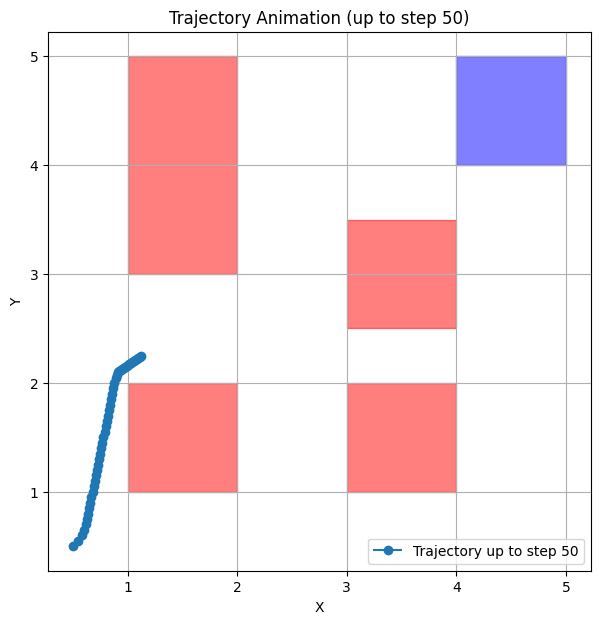

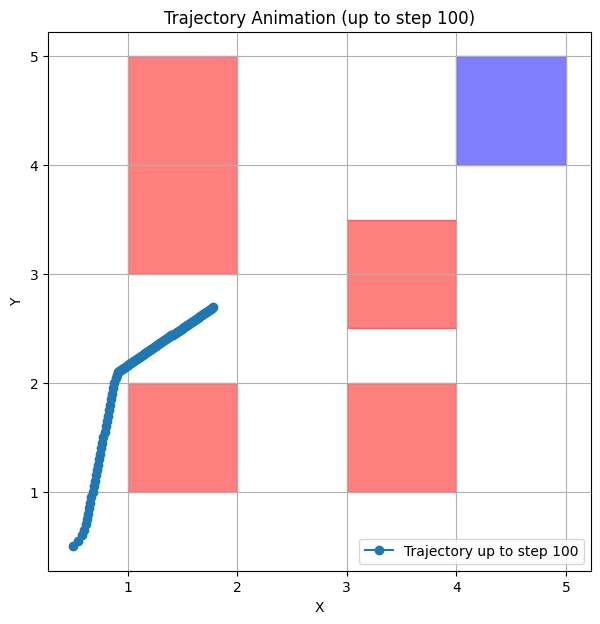

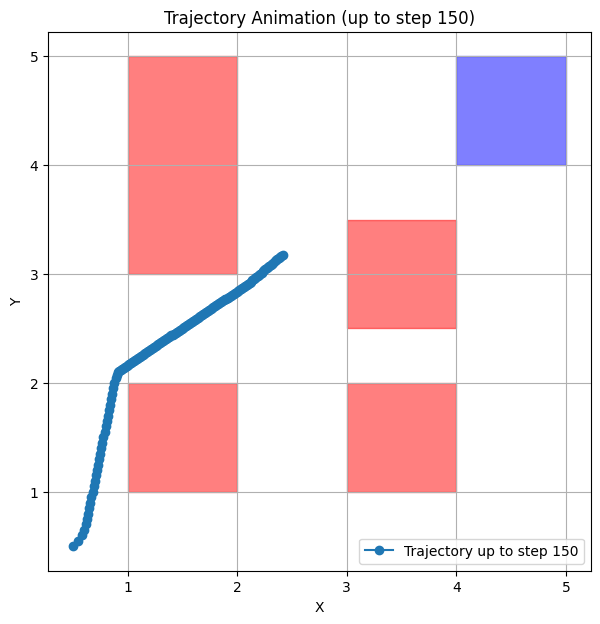

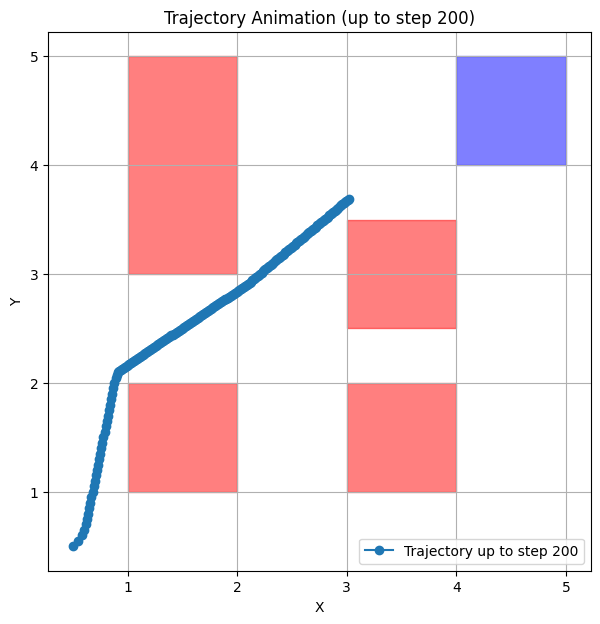

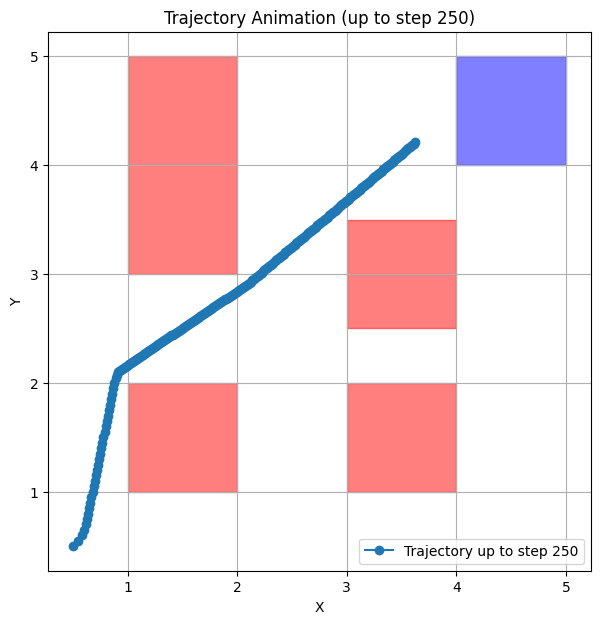

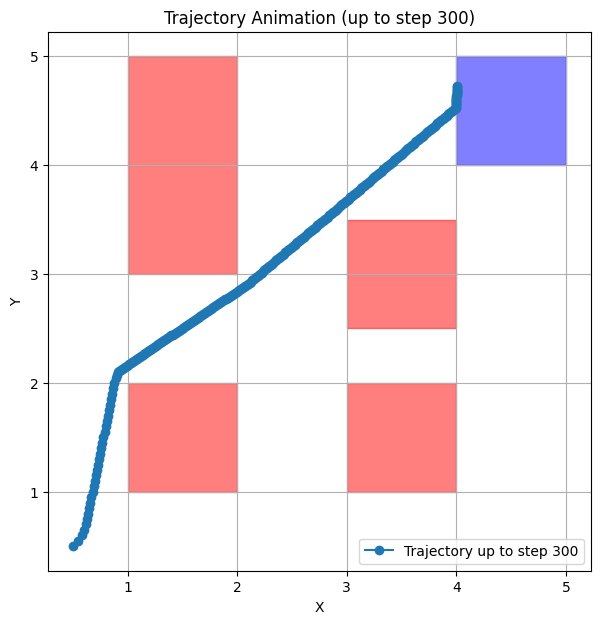

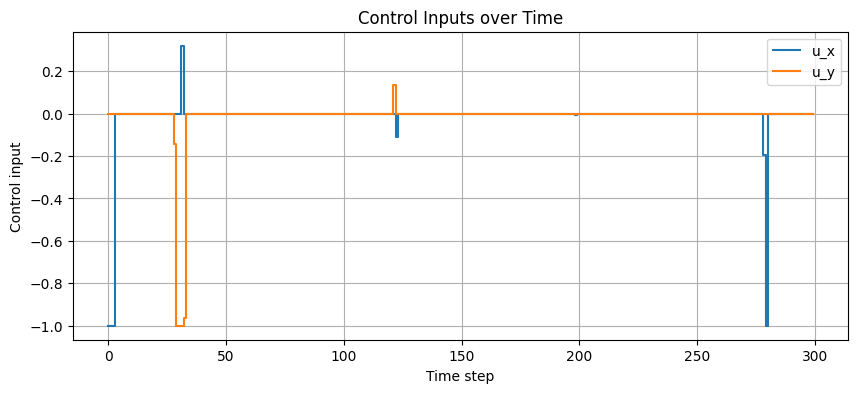

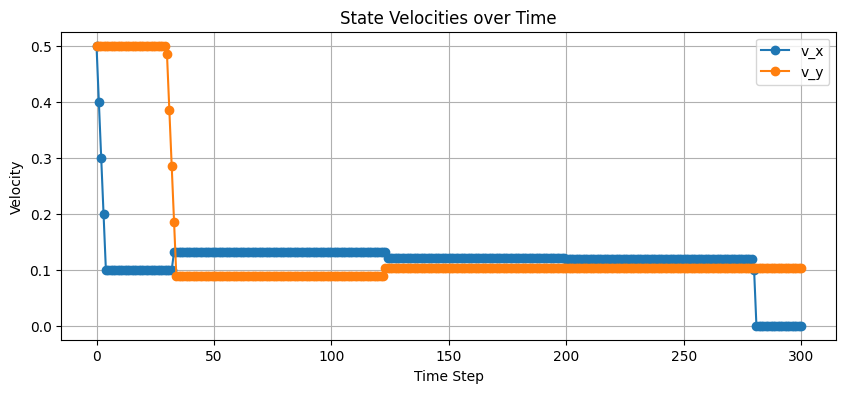

In [337]:
# Extract and plot solution
if milp_guro_model.Status == GRB.OPTIMAL:

    # Print optimization time and resource usage
    print(f"Optimization Time for {N} steps: {end_time - start_time:.4f} seconds")
    print(f"CPU Usage: {psutil.cpu_percent()}%")
    print(f"Memory Usage: {process.memory_info().rss / 1024 ** 2:.2f} MB")

    # # Plot Obstacles
    # for region in unsafe_regions:
    #     lower, upper = region
    #     bottom_left = [lower[0], lower[2]]
    #     width = upper[0] - lower[0]
    #     height = upper[2] - lower[2]
    #     plt.gca().add_patch(plt.Rectangle(bottom_left, width, height, color='red', alpha=0.5))

    # # Plot Target Set
    # bottom_left = [target_set[0][0], target_set[0][2]]
    # width = target_set[1][0] - target_set[0][0]
    # height = target_set[1][2] - target_set[0][2]
    # plt.gca().add_patch(plt.Rectangle(bottom_left, width, height, color='blue', alpha=0.5))

    # Extract Trajectory
    traj = np.array(
        [[x[k, i].X for i in range(4)] 
         for k in range(N + 1)])

    # Animated plotting
    step_size = 50
    for k in range(step_size, N + 1, step_size):
        plt.figure(figsize=(7, 7))
            # Plot Obstacles
        for region in unsafe_regions:
            lower, upper = region
            bottom_left = [lower[0], lower[2]]
            width = upper[0] - lower[0]
            height = upper[2] - lower[2]
            plt.gca().add_patch(plt.Rectangle(bottom_left, width, height, color='red', alpha=0.5))

        # Plot Target Set
        bottom_left = [target_set[0][0], target_set[0][2]]
        width = target_set[1][0] - target_set[0][0]
        height = target_set[1][2] - target_set[0][2]
        plt.gca().add_patch(plt.Rectangle(bottom_left, width, height, color='blue', alpha=0.5))

        # Plot Extension 3.1 target
        # bottom_left = [bottom_right_target[0][0], bottom_right_target[0][2]]
        # width = bottom_right_target[1][0] - bottom_right_target[0][0]
        # height = bottom_right_target[1][2] - bottom_right_target[0][2]
        # plt.gca().add_patch(plt.Rectangle(bottom_left, width, height, color='blue', alpha=0.5))

        plt.plot(traj[:k, 0], traj[:k, 2], marker='o', label=f'Trajectory up to step {k}')
        plt.title(f"Trajectory Animation (up to step {k})")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.grid(True)
        plt.legend()
        plt.pause(0.5)
        plt.close()

    # plt.plot(traj[:, 0], traj[:, 2], marker='o')
    # plt.title("Trajectory (Gurobi)")
    # plt.xlabel("X")
    # plt.ylabel("Y")
    # plt.grid(True)
    # plt.show()

    # Extract control inputs
    control_inputs = np.array([
        [u[k, i].X for i in range(2)]
        for k in range(N)])
    
    # ---- Plot Control Inputs ----
    plt.figure(figsize=(10, 4))
    plt.step(range(N), control_inputs[:, 0], label='u_x')
    plt.step(range(N), control_inputs[:, 1], label='u_y')
    plt.xlabel('Time step')
    plt.ylabel('Control input')
    plt.title('Control Inputs over Time')
    plt.grid(True)
    plt.legend()
    plt.show()

    # ---- Plot Velocity over time steps ----
    plt.figure(figsize=(10, 4))
    plt.plot(range(N + 1), traj[:, 1], label='v_x', marker='o')
    plt.plot(range(N + 1), traj[:, 3], label='v_y', marker='o')
    plt.xlabel("Time Step")
    plt.ylabel("Velocity")
    plt.title("State Velocities over Time")
    plt.grid(True)
    plt.legend()

    
else:
    print("No feasible solution found.")

## References
-   Afonso RJM, Maximo MROA, Galvão RKH. Task allocation and trajectory planning for multiple agents in the presence of obstacle and connectivity constraints with mixed-integer linear programming. Int J Robust Nonlinear Control. 2020; 30: 5464–5491. https://doi.org/10.1002/rnc.5092

-   SchouwenaarsT, MoorDB, FeronE, HowJP. Mixed integer programming for multi-vehicle path planning. Paper presented at: Proceedings of the 2001 European Control Conference (ECC). Proceedings of the European Control Conference (ECC); 2001:2603-2608; Porto, Portugal. 